## Map import & visualization

### Utils

In [0]:
import os
import numpy as np
from matplotlib import pyplot as plt

In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving easy_1.npy to easy_1.npy
Saving easy_2.npy to easy_2.npy
Saving indoor_1.npy to indoor_1.npy
User uploaded file "easy_1.npy" with length 1280128 bytes
User uploaded file "easy_2.npy" with length 1280128 bytes
User uploaded file "indoor_1.npy" with length 1280128 bytes


In [0]:
# considered_file = list(uploaded.keys())[2]
considered_file = 'indoor_1.npy'
gmap = np.load('/content/' + considered_file)

In [0]:
grid_resolution = 0.05
colormap = plt.get_cmap('jet')

color_old_unknown = -1
color_old_known = 0
color_old_obstacle = 100

if colormap == None or colormap.name == 'viridis':
  color_unknown = -80
  color_known = 0
  color_obstacle = 150
  color_target = 200
  color_robot = -60
  color_other = 180
elif colormap.name == 'jet':
  color_unknown = -100
  color_known = -50
  color_obstacle = 80
  color_target = 1
  color_robot = 100
  color_other = 30

def get_drawable_map(grid, target_pose = None, target_dim = 0.15, robot_pose = None, other_poses = []):

    drawable_map = np.copy(grid)
    drawable_map[drawable_map == color_old_unknown] = color_unknown # recoloring unknown
    drawable_map[drawable_map == color_old_known] = color_known # recoloring known
    drawable_map[drawable_map == color_old_obstacle] = color_obstacle # recoloring obstacles
    
    if other_poses != None and len(other_poses) > 0:
      other_dim = 4
      for i, pose in enumerate(other_poses):
        if(pose != None):
          other_x, other_y = odom_to_grid(pose)
          cols_index = slice(other_x - (other_dim//2), other_x + (other_dim//2) + 1)
          rows_index = slice(other_y - (other_dim//2), other_y + (other_dim//2) + 1)
          drawable_map[rows_index, cols_index] = color_other # recoloring other

    if robot_pose != None:
      robot_dim = 6
      robot_x, robot_y = odom_to_grid(robot_pose)
      cols_index = slice(robot_x - (robot_dim//2), robot_x + (robot_dim//2) + 1)
      rows_index = slice(robot_y - (robot_dim//2), robot_y + (robot_dim//2) + 1)
      drawable_map[rows_index, cols_index] = color_robot # recoloring robot
      
    if target_pose != None:
      target_dim = np.maximum(4, np.ceil(target_dim / grid_resolution).astype(int))
      target_x, target_y = odom_to_grid(target_pose)
      cols_index = slice(target_x - (target_dim//2), target_x + (target_dim//2) + 1)
      rows_index = slice(target_y - (target_dim//2), target_y + (target_dim//2) + 1)
      drawable_map[rows_index, cols_index] = color_target # recoloring target

    return drawable_map


def odom_to_grid(odom):
    x_grid = round(odom[0] / grid_resolution) + 200
    y_grid = round(odom[1] / grid_resolution) + 200
    return int(x_grid), int(y_grid)

def grid_to_odom(grid):
    x_odom = (grid[0] - 200) * grid_resolution
    y_odom = (grid[1] - 200) * grid_resolution
    return x_odom, y_odom


i1, i2 = 0.024, 1.076
g1, g2 = odom_to_grid((i1, i2))
o1, o2 = grid_to_odom((g1, g2))

print('actual \t', i1, i2)
print('grid \t', g1, g2)
print('back \t', o1, o2)
np.testing.assert_allclose(i1, o1, atol=grid_resolution/2)
np.testing.assert_allclose(i2, o2, atol=grid_resolution/2)

actual 	 0.024 1.076
grid 	 200 222
back 	 0.0 1.1


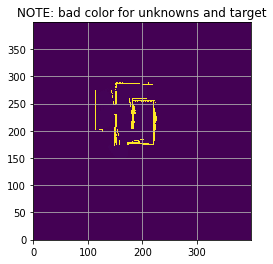

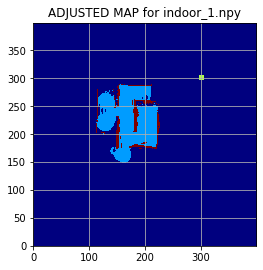

In [0]:
plt.figure(figsize = (4,4))
plt.grid()
plt.title('NOTE: bad color for unknowns and target')
plt.imshow(gmap, interpolation='nearest', origin='lower')

plt.figure(figsize = (4,5))
plt.grid()
plt.title('ADJUSTED MAP for ' + considered_file)
plt.imshow(get_drawable_map(gmap, (5, 5), 0.4), interpolation='nearest', origin='lower', cmap=colormap)

### Demo

In [0]:
# easy1 target (x,y): (0.636197328568,-0.817661881447)
# easy2 target (x,y): (2.61609911919,3.43398237228)
# easy3 target (x,y): 

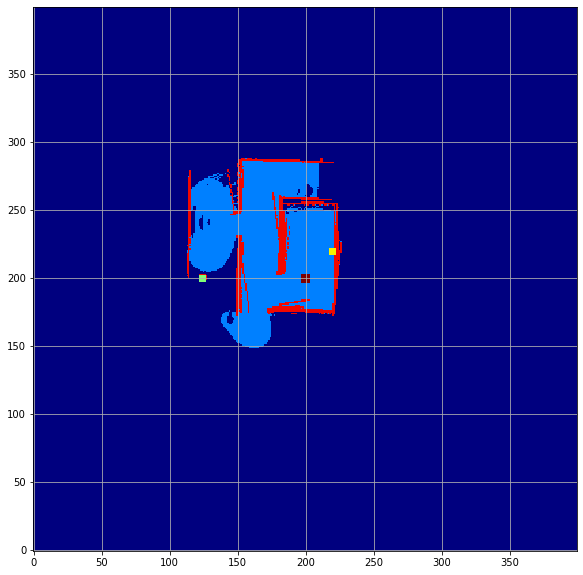

In [0]:
plt.figure(figsize = (10,10))
plt.grid()
tmp_map = get_drawable_map(gmap, target_pose=(-3.8,0), robot_pose=(0,0), other_poses=[(1,1)])
plt.imshow(tmp_map, interpolation='nearest', origin='lower', cmap=colormap)

## Obstacle avoidance

In [0]:
robot_width = 0.20 # meters


def pose_ahead(x, y, theta, meters_ahead = 0.05):
  ahead_x = meters_ahead * np.cos(theta) + x
  ahead_y = meters_ahead * np.sin(theta) + y
  return ahead_x, ahead_y


def has_facing_obstacle(grid, x, y, theta, step = grid_resolution, robot_visibility = 1.2, robot_width = 0.20):

  obstacle_facing = False
  obstacle_distance = None
  obstacle_odom = None

  adjacent_cells = np.ceil(robot_width/step/2).astype(int)
  theta_orthogonal = theta + np.pi/2

  for i in range(int(robot_visibility//step)):

    distance = step * i
    ahead_odom = pose_ahead(x, y, theta, distance)
    ahead_grid = odom_to_grid(ahead_odom)

    if grid[ahead_grid[::-1]] == 100:
      obstacle_facing = True
    else:
      ahead_grid_near = []
      for j in range(1, adjacent_cells + 1):
        l = odom_to_grid(pose_ahead(ahead_odom[0], ahead_odom[1], theta_orthogonal, j *  0.05))
        r = odom_to_grid(pose_ahead(ahead_odom[0], ahead_odom[1], theta_orthogonal, j * -0.05))
        ahead_grid_near.append(l)
        ahead_grid_near.append(r)
      
      ahead_grid_near = list(set(ahead_grid_near))
      # print('grid:', ahead_grid, '\t adj:', ahead_grid_list, '\t odom:', ahead_odom)

      for j in range(len(ahead_grid_near)):
        if grid[ahead_grid_near[j][::-1]] == 100: 
          obstacle_facing = True
          break

    if obstacle_facing:
      obstacle_distance = distance
      obstacle_odom = ahead_odom
      break

  return obstacle_facing, obstacle_distance, obstacle_odom


def draw_circle(angle):
  fig, ax = plt.subplots()
  fig.set_size_inches(3,3)
  ax.set_xlim(-1.1,1.1)
  ax.set_ylim(-1.1,1.1)
  ax.grid()
  ax.axhline(y=0, color='k')
  ax.axvline(x=0, color='k')
  ax.add_patch(plt.Circle((0, 0), 1, color='r', fill=False))
  ax.plot(np.cos(angle), np.sin(angle), 'bo')

### Random exploration controller

The robot sees `robot_visibility` meters in front of itself.

- If no obstacle is present in front of the robot, it goes straight ahead until an obstacle is reached.
- As soon as an obstacle perfectly facing the robot is reached (also the robot widht is considered here), it will turn around by looking for the best way to follow, computing the best rotation direction based on the distance with obstacles at the left and at the right.
- If the robot get stucked in a situation where it cannot avoid the obstacles by just slighlty rotating from its current orientation, then a random `theta` is computed for the next move. 


In [0]:
from IPython.display import clear_output


def controller(grid, current_x, current_y, current_theta, step = 0.1, obs_stucked_max = 8):
  obs_count = 0

  while True:
    clear_output(wait=True)

    # draw current situation
    draw_circle(current_theta)
    obs_present, obs_dist, obs_odom = has_facing_obstacle(grid, current_x, current_y, current_theta)
    plt.figure(figsize = (10,10))
    plt.grid()
    plt.imshow(get_drawable_map(grid, target_pose=(5,7), robot_pose=(current_x, current_y), other_poses=[obs_odom]), interpolation='nearest', origin='lower', cmap=colormap)
    plt.pause(0.3)

    if(not obs_present): # movement ahead
      obs_count = 0
      current_x, current_y = pose_ahead(current_x, current_y, current_theta, meters_ahead=step) # publish linear velocity here

    else: # look for a free path by turning around
      obs_count += 1
      if obs_count > obs_stucked_max: # prevent the robot to be stucked in trying the same orientations over and over
        current_theta += np.deg2rad(np.random.uniform(-130, 130))

      # evaluating left and right side of the robot to choose the turning direction
      left_distances = []
      right_distances = []
      for i in range(1, 45, 5):
        _, dist_left, _ = has_facing_obstacle(grid, current_x, current_y, current_theta + np.deg2rad(i), robot_visibility=2.)
        _, dist_right, _ = has_facing_obstacle(grid, current_x, current_y, current_theta - np.deg2rad(i), robot_visibility=2.)
        left_distances.append(dist_left or 4)
        right_distances.append(dist_right or 4)

      # once both sides are evaluated, the robot tries to turn the preferred way for finding a free path
      previous_obs_dist = 0
      deg_delta = 5 if np.mean(left_distances) > np.mean(right_distances) else -5
      while obs_present and obs_dist * 1.8 >= previous_obs_dist: # allows to take still-blocked ways that are better than before
        previous_obs_dist = obs_dist
        current_theta += np.deg2rad(deg_delta) # step-by-step research (could be improved by adding decay on `deg_delta`)
        obs_present, obs_dist, obs_odom = has_facing_obstacle(grid, current_x, current_y, current_theta)




start_x, start_y = 0, 1
start_theta = np.pi/2

controller(gmap, start_x, start_y, start_theta)

## Path Planning

In [0]:
import math

def euclidean_distance_tuple(current_pose, target_pose):
  return math.sqrt(math.pow((target_pose[0] - current_pose[0]), 2) +
					          math.pow((target_pose[1] - current_pose[1]), 2))


class GraphNode:
  def __init__(self, pose, g_score, prev_node_pose, goal_pose):
    self.pose = pose
    self.g_score = g_score # actual cost
    self.h_score = 0 if goal_pose == None else euclidean_distance_tuple(self.pose, goal_pose) # heuristic cost
    self.prev_node_pose = prev_node_pose

  def f_score(self):
    return self.g_score + self.h_score # priority cost

  def __str__(self):
    return str(self.pose) + ", g:" + str(self.g_score) + ", f:" + "{:.3f}".format(self.f_score()) + ", prev:" + str(self.prev_node_pose)



def get_neighbourhood(grid, grid_pose, robot_width=0.20, grid_resolution=0.05):

  # due to the robot width, cells next to the obstacles must be ignored
  collision_cells = np.ceil(robot_width/grid_resolution/2).astype(int)

  nrows = grid.shape[0]
  ncols = grid.shape[1]
  row = grid_pose[1] # y=row
  col = grid_pose[0] # x=col
  neighbourhood = []

  # When reading this code, please remember that while pose is expressed as (X,Y),
  # the matrix indexing for `grid` is instead to be done as (Y,X).
  # Moreover, the Y is flipped in the map (see images above), then for moving the
  # robot UP we actually need to increment Y (rows index + 1)
  # instead of decreasing it (such as it would happen in a normal matrix).

  if col > 0 and grid[row, col - min(col, collision_cells)] != color_old_obstacle:
    neighbourhood.append((col - 1, row)) # left
  if col < ncols - 1 and grid[row, col + min(ncols - col - 1, collision_cells)] != color_old_obstacle:
    neighbourhood.append((col + 1, row)) # right

  if row > 0 and grid[row - min(row, collision_cells), col] != color_old_obstacle:
    neighbourhood.append((col, row - 1)) # down
  if row < nrows - 1 and grid[row + min(nrows - row - 1, collision_cells), col] != color_old_obstacle:
    neighbourhood.append((col, row + 1)) # up

  if col > 0 and row > 0 and grid[row - min(row, collision_cells), col - min(col, collision_cells)] != color_old_obstacle:
    neighbourhood.append((col - 1, row - 1)) # diagonal left-down
  if col > 0 and row < nrows - 1 and grid[row - min(nrows - row - 1, collision_cells), col - min(col, collision_cells)] != color_old_obstacle:
    neighbourhood.append((col - 1, row + 1)) # diagonal left-up

  if col < ncols - 1 and row > 0 and grid[row - min(row, collision_cells), col + min(ncols - col - 1, collision_cells)] != color_old_obstacle:
    neighbourhood.append((col + 1, row - 1)) # diagonal right-down
  if col < ncols - 1 and row < nrows - 1 and grid[row + min(nrows - row - 1, collision_cells), col + min(ncols - col - 1, collision_cells)] != color_old_obstacle:
    neighbourhood.append((col + 1, row + 1)) # diagonal right-up

  # print(grid_pose, neighbourhood)
  return neighbourhood


def get_complete_path(nodes_set, node):
  path = [node.pose]
  while node.prev_node_pose != None:
    path.append(node.prev_node_pose)
    node = nodes_set[node.prev_node_pose]
  return path[::-1]

### A* and Dijkstra algorithms

In [0]:
def path_planning(grid, start_odom, goal_odom, goal_color = None):
  # Applies A* or Dijkstra depending on the fact that `goal_odom` is specified or not

  start_grid = odom_to_grid(start_odom)
  goal_grid = None if goal_odom == None else odom_to_grid(goal_odom)
  
  if goal_grid == None and goal_color == None: 
    raise Exception('You must have either a goal pose or color.')

  open_set = dict() # nodes to explore
  closed_set = dict() # already explored nodes
  
  start_node = GraphNode(start_grid, 0, None, goal_grid)
  open_set[start_node.pose] = start_node


  while len(open_set) > 0:

    # get the node with minimum f_score
    chosen_idx = min(open_set, key = lambda dict_idx: open_set[dict_idx].f_score()) 
    current_node = open_set[chosen_idx]
    
    success = True if goal_grid == None or current_node.pose == goal_grid else False
    success = True if success and (goal_color == None or grid[current_node.pose[::-1]] == goal_color) else False

    if success: 
      return [grid_to_odom(p) for p in get_complete_path(closed_set, current_node)] # success: goal reached

    del open_set[chosen_idx]
    closed_set[chosen_idx] = current_node

    neighbourhood = get_neighbourhood(grid, current_node.pose) # list of neighbours poses (tuple)
    
    for i, neighbour in enumerate(neighbourhood):
      
      if neighbour in closed_set:
          continue # already explored

      g_score = current_node.g_score + euclidean_distance_tuple(current_node.pose, neighbour)

      if neighbour not in open_set: # new node
          open_set[neighbour] = GraphNode(neighbour, g_score, current_node.pose, goal_grid)
      
      elif open_set[neighbour].g_score > g_score: # best path for reaching the node `neighbour` 
              open_set[neighbour].g_score = g_score
              open_set[neighbour].prev_node_pose = current_node.pose

  return None # failure: open_set is empty but goal was never reached

### Goal reaching

Init pose:  (0, 1)
Goal pose:  (-3, 1)
Path plan:  [(0.0, 1.0), (-0.05, 0.9500000000000001), (-0.1, 0.9), (-0.15000000000000002, 0.8500000000000001), (-0.2, 0.8), (-0.25, 0.75), (-0.30000000000000004, 0.7000000000000001), (-0.35000000000000003, 0.65), (-0.4, 0.6000000000000001), (-0.45, 0.55), (-0.5, 0.5), (-0.55, 0.45), (-0.6000000000000001, 0.4), (-0.65, 0.35000000000000003), (-0.65, 0.30000000000000004), (-0.7000000000000001, 0.25), (-0.75, 0.2), (-0.8, 0.15000000000000002), (-0.8500000000000001, 0.2), (-0.9, 0.15000000000000002), (-0.9500000000000001, 0.2), (-1.0, 0.25), (-1.05, 0.30000000000000004), (-1.1, 0.35000000000000003), (-1.1500000000000001, 0.4), (-1.2000000000000002, 0.45), (-1.25, 0.5), (-1.3, 0.55), (-1.35, 0.6000000000000001), (-1.4000000000000001, 0.65), (-1.4500000000000002, 0.7000000000000001), (-1.5, 0.75), (-1.55, 0.8), (-1.6, 0.8500000000000001), (-1.6500000000000001, 0.9), (-1.7000000000000002, 0.9500000000000001), (-1.75, 1.0), (-1.8, 1.05), (-1.85, 1.1), (-1.

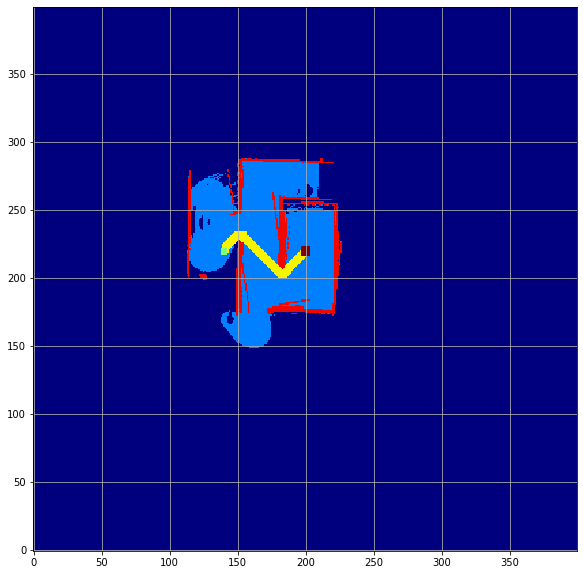

In [0]:
ip = (0,1)
gp = (-3,1)
result = path_planning(gmap, ip, gp)
print('Init pose: ', ip)
print('Goal pose: ', gp)
print('Path plan: ', result)
print('Path length: ', len(result) if result != None else 0)

plt.figure(figsize = (10,10))
plt.grid()
plt.imshow(get_drawable_map(gmap, target_pose=gp, robot_pose=ip, other_poses=result), interpolation='nearest', origin='lower', cmap=colormap)

### Looking for unknown areas

Init pose:  (0.5, -0.5)
Path plan:  [(0.5, -0.5), (0.45, -0.5), (0.4, -0.5), (0.35000000000000003, -0.5), (0.30000000000000004, -0.5), (0.25, -0.5), (0.2, -0.5), (0.15000000000000002, -0.55), (0.1, -0.6000000000000001), (0.05, -0.6000000000000001), (0.0, -0.6000000000000001), (-0.05, -0.6000000000000001), (-0.1, -0.6000000000000001), (-0.15000000000000002, -0.6000000000000001), (-0.2, -0.6000000000000001), (-0.25, -0.6000000000000001), (-0.30000000000000004, -0.65), (-0.35000000000000003, -0.65), (-0.4, -0.65), (-0.45, -0.65), (-0.5, -0.65), (-0.55, -0.65), (-0.6000000000000001, -0.65), (-0.65, -0.65), (-0.7000000000000001, -0.65), (-0.75, -0.65), (-0.8, -0.65), (-0.8500000000000001, -0.65), (-0.9, -0.65), (-0.9500000000000001, -0.65), (-1.0, -0.65), (-1.05, -0.7000000000000001), (-1.1, -0.75), (-1.1500000000000001, -0.8), (-1.2000000000000002, -0.8500000000000001), (-1.25, -0.9), (-1.3, -0.9500000000000001), (-1.35, -1.0), (-1.4000000000000001, -1.05), (-1.4500000000000002, -1.1), (-1

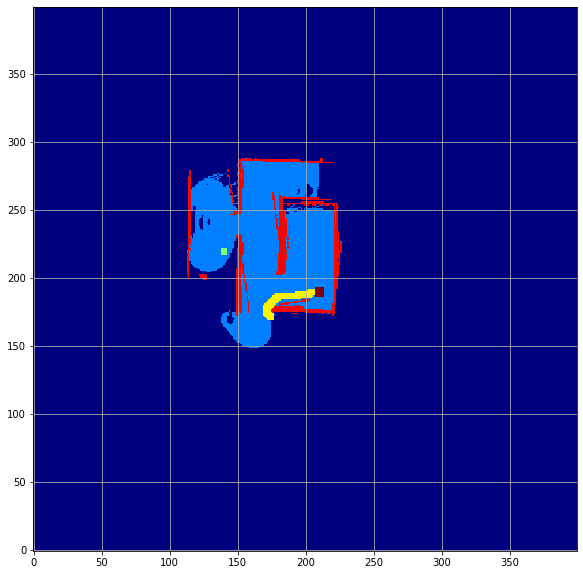

In [0]:
ip = (0.5,-0.5)
result = path_planning(gmap, ip, None, -1)
print('Init pose: ', ip)
print('Path plan: ', result)
print('Path length: ', len(result) if result != None else 0)

plt.figure(figsize = (10,10))
plt.grid()
plt.imshow(get_drawable_map(gmap, target_pose=gp, robot_pose=ip, other_poses=result), interpolation='nearest', origin='lower', cmap=colormap)